In [48]:
# read first Bengio et al. 2003 (MLP language model) paper

In [49]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [50]:
words = open("data/names.txt", "r").read().splitlines()
print(len(words))
print(words[:8])

32033
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [51]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [52]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [53]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g) * 0.1
b1 = torch.randn(200, generator=g) * 0.02
W2 = torch.randn((200, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [54]:
sum(p.nelement() for p in parameters)

for p in parameters:
    p.requires_grad = True

# how to determine a reasonable learning rate
lre  = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lossi = []
stepi = []

In [55]:
for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    if i % 10000 == 0:
        print(f"{i}: {loss.item()}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -0.01 * p.grad
    
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

0: 3.951526165008545
10000: 2.275712013244629
20000: 2.750166654586792
30000: 2.2538766860961914
40000: 2.1925361156463623


2.369602680206299


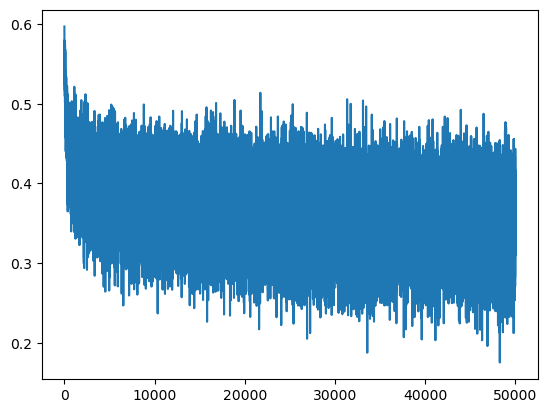

In [56]:
print(loss.item())
plt.plot(stepi, lossi);

In [58]:
# dev loss
torch.no_grad()
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.2461137771606445


In [137]:
# data: training split, dev/validation split, test split
# 80%, 10%, 10%
# train the params, train the hyper-params, evaluate the performance